# Showcase model

In [1]:
library(here)
source(here("setup.R"))


here() starts at /Users/stefan/workspace/work/phd/thesis



## Parameters

In [2]:
theta_showcase <- read_csv(here("data/results/4_showcase_model/thetas.csv")) %>%
    rename("\\rho" = 2)
theta_showcase

variances <- theta_showcase %>%
    mutate(across(where(is.numeric), ~ exp(.x)))

sds <- variances %>%
    mutate(across(where(is.numeric), ~ sqrt(.x)))

var_log_M <- variances %>%
    filter(method == "MLE") %>%
    pull(M)

var_M <- exp(var_log_M) - 1
sd_M <- sqrt(var_M)

c("var_M" = var_M, "sd_M" = sd_M)


method,\rho,W,q,M,W_q
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
manual,-13.815511,-4.605170,-1.386294,-9.210340,-4.6051702
initial,-8.422745,-7.476381,-4.235409,-3.988990,-0.4154693
MLE,-8.422722,-7.476400,-4.225735,-3.988944,-0.4137567


var_M      sd_M 
0.0186918 0.1367180

### `tables/showcase-parameters.tex`

In [3]:
# use scientific notation
sds %>%
    rename_with(function(col) str_glue("$\\hat\\sigma_{{ {col} }}$"), where(is.numeric)) %>%
    kable(format = "latex", format.args = list(scipen = 2, digits = 2), booktabs = T, escape = F) %>%
    cat(., file = here("tables/showcase-parameters.tex"))


## Raw data



In [4]:
rep_tri <- read_csv(here("data/processed/RKI_4day_rt.csv"))


## Predictions

In [5]:
default_probs <- c(0.01, 0.025, 0.05 * 1:19, 0.975, 0.99)
read_predictions <- function(fname, dates, variables, probs = default_probs) {
    np <- import("numpy")
    predictions <- np$load(fname)

    dimnames(predictions) <- list(
        "type" = c("mean", "sd", probs),
        "date" = as.character(dates),
        "variable" = variables
    )

    df_predictions <- melt(predictions) %>%
        mutate(date = ymd(date)) %>%
        pivot_wider(id_cols = c(date, variable), names_from = "type", values_from = "value")
    df_predictions
}
df_showcase <- read_predictions(
    here("data/results/4_showcase_model/predictions.npy"),
    seq(ymd("2020-04-05"), ymd("2020-09-01"), by = "1 day"),
    c("I", "$\\rho$", "M", "W", "running_W", "$p^s_1$", "$p^s_2$", "$p^s_3$", "$p^s_4$", "$p_1$", "$p_2$", "$p_3$", "$p_4$", "$W_{q_1}", "W_{q_2}", "W_{q_3}")
)


### `figures/showcase_prediction_intervals_I_rho.tex`

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


pdf 
  2

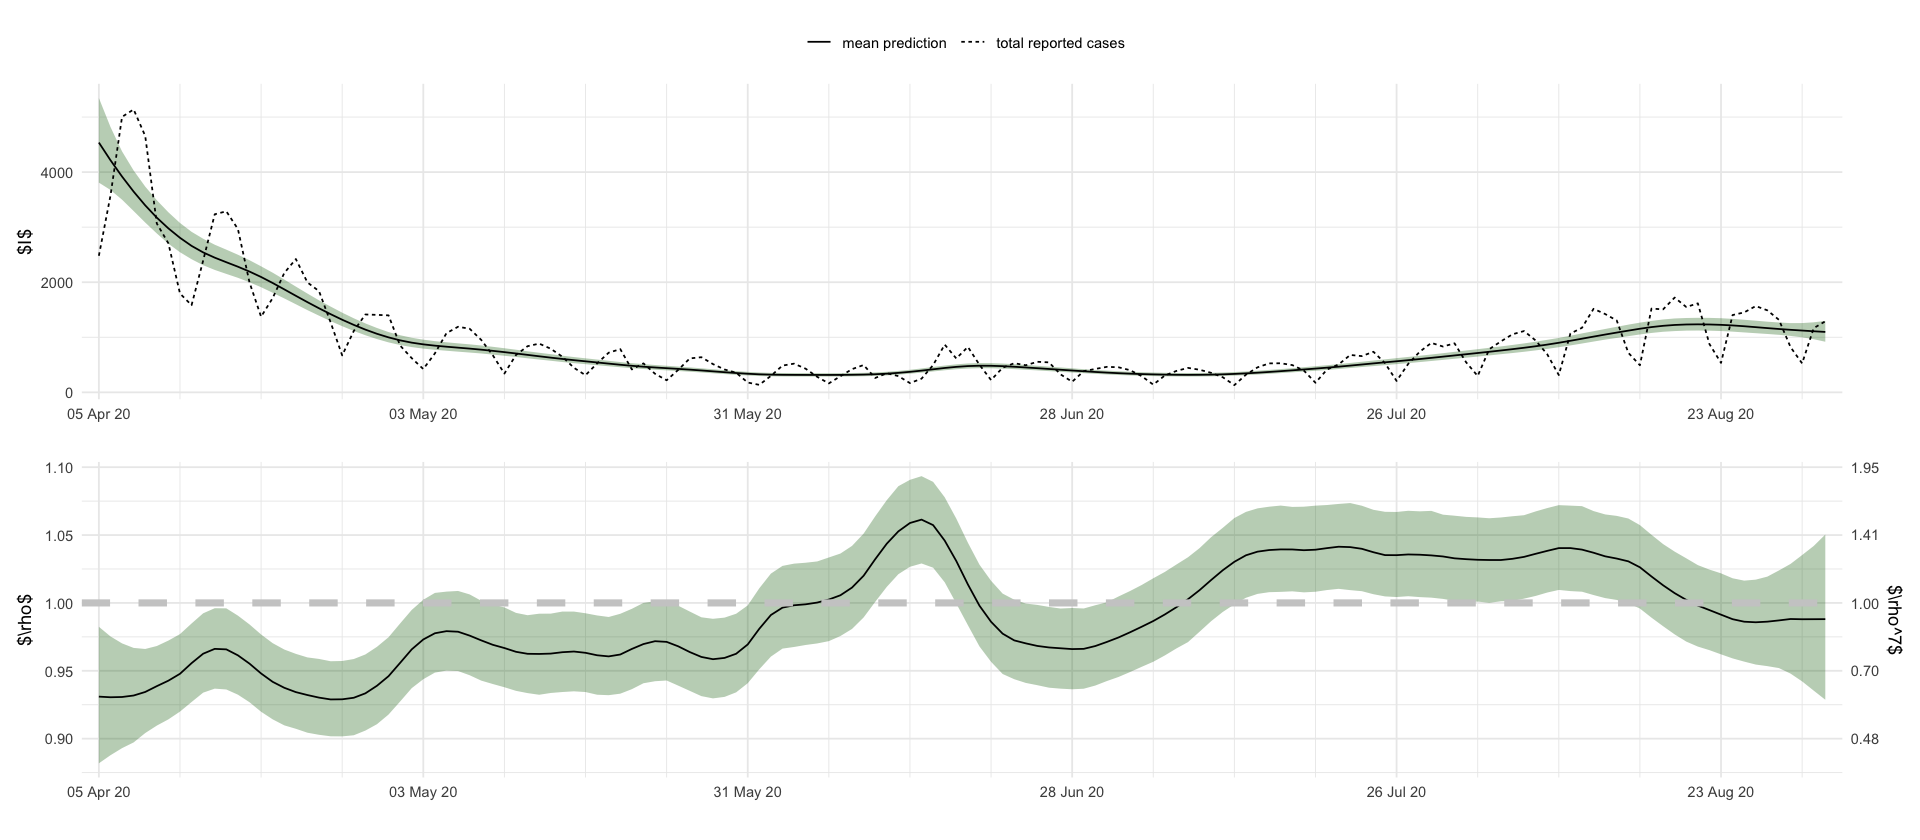

In [6]:
total_df <- rep_tri %>%
    mutate(total = `1` + `2` + `3` + `4`) %>%
    select(date = county_date, total)

plt_I <- df_showcase %>%
    filter(variable == "I") %>%
    ggplot(aes(date, mean)) +
    geom_ribbon(aes(date, ymin = `0.025`, ymax = `0.975`), fill = "darkgreen", alpha = .3) +
    geom_line(aes(linetype = "mean prediction")) +
    geom_line(aes(y = total, linetype = "total reported cases"), data = filter(total_df, date <= max(df_showcase$date))) +
    labs(x = "", y = "$I$", linetype = "") +
    scale_x_four_weekly()

plt_rho <- df_showcase %>%
    filter(variable == "$\\rho$") %>%
    ggplot(aes(date, mean)) +
    geom_ribbon(aes(date, ymin = `0.025`, ymax = `0.975`), fill = "darkgreen", alpha = .3) +
    geom_line() +
    geom_hline(yintercept = 1, linetype = "dashed", color = "grey80", size = 2) +
    # geom_text(x = min(df_showcase$date), y = 1.00, label = "threshold for \n exponential growth", color = "grey80", vjust = -1, hjust = .15, size = 2) +
    labs(x = "", y = "$\\rho$") +
    scale_y_continuous(
        sec.axis = sec_axis(~ .^7, name = "$\\rho^7$", breaks = round(c(.9, .95, 1., 1.05, 1.1, 1.15)^7, 2))
    ) +
    scale_x_four_weekly()

plt_I / plt_rho + plot_layout(guides = "collect") & theme(legend.position = "top")

ggsave_tikz(here("tikz/showcase_prediction_intervals_I_rho.tex"), height = default_height)


### `figures/showcase_prediction_intervals.tex`

pdf 
  2

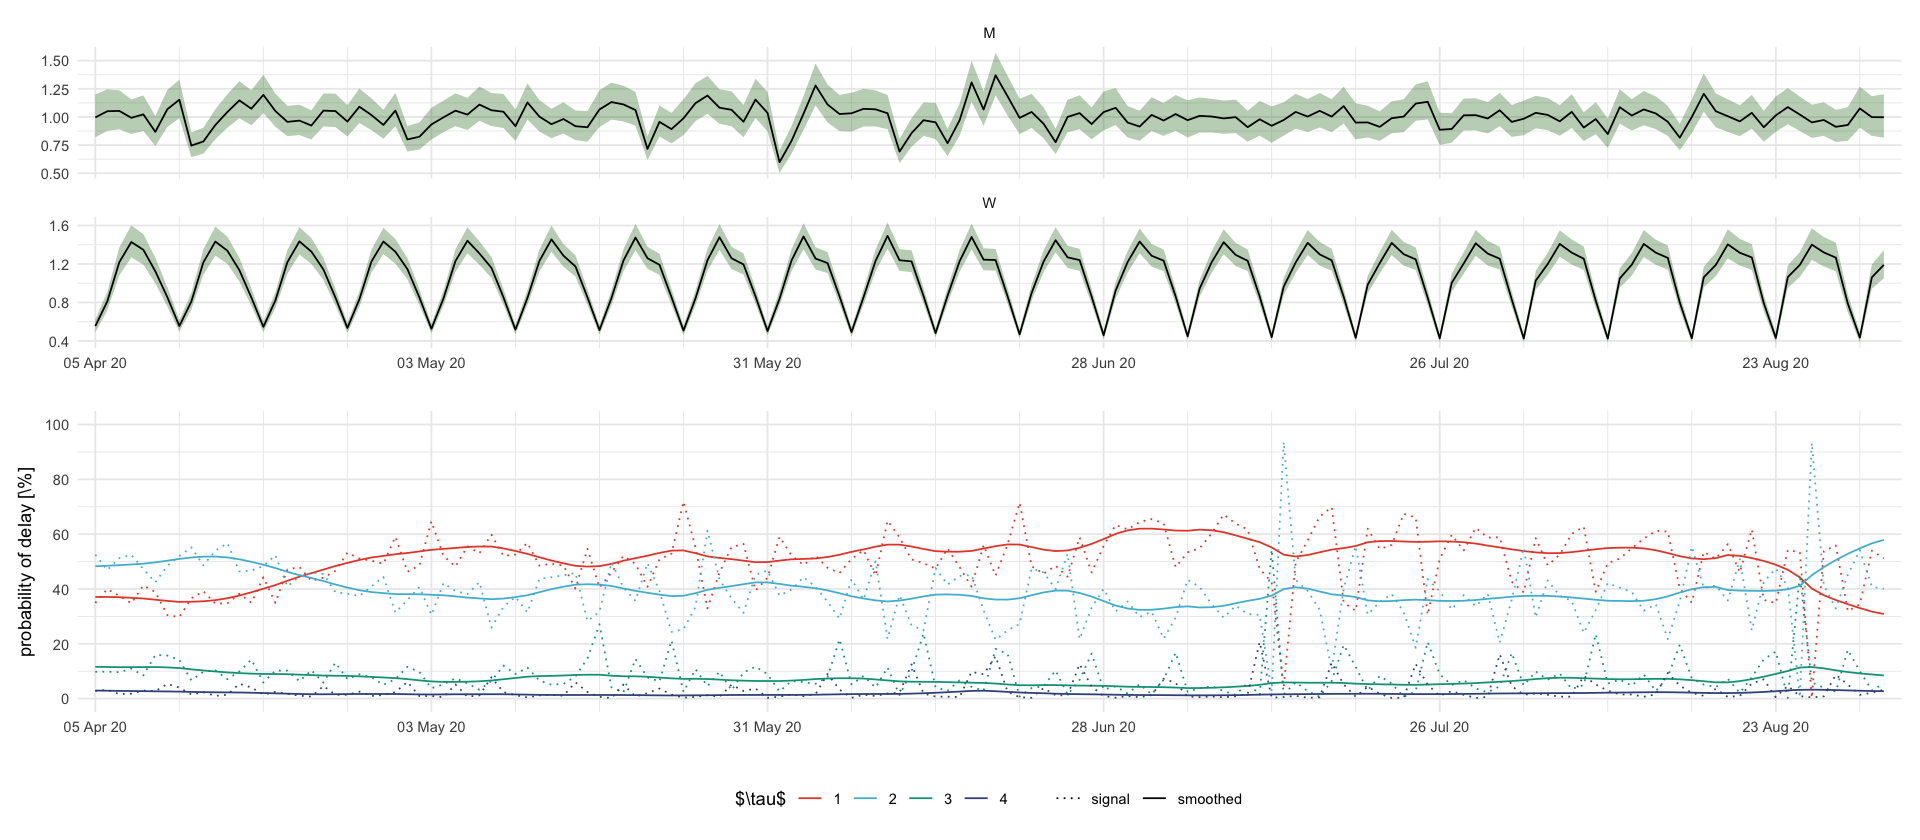

In [7]:
plt_MW <- df_showcase %>%
    filter((variable %in% c("M", "W"))) %>%
    ggplot(aes(date, mean)) +
    geom_ribbon(aes(date, ymin = `0.025`, ymax = `0.975`), fill = "darkgreen", alpha = .3) +
    geom_line() +
    facet_wrap(~variable, scales = "free_y", ncol = 1) +
    labs(x = "", y = "")

plt_p <- df_showcase %>%
    filter(str_starts(variable, "\\$p")) %>%
    mutate(delay = str_extract(variable, "\\d+")) %>%
    select(date, mean, variable, delay) %>%
    mutate(variable = ifelse(str_detect(variable, "s"), "smoothed", "signal")) %>%
    ggplot(aes(date, 100 * mean, color = delay, linetype = variable)) +
    geom_line() +
    scale_y_continuous(breaks = 20 * 0:5, limits = c(0, 1) * 100) +
    scale_linetype_manual(values = c("signal" = "dotted", "smoothed" = "solid")) +
    labs(color = "$\\tau$", x = "", y = "probability of delay [\\%]", linetype = "")

plt_MW / plt_p + plot_layout(guides = "collect") & theme(legend.position = "bottom") & scale_x_four_weekly()
# theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggsave_tikz(here("tikz/showcase_prediction_intervals.tex"), height = 1.5 * default_height)


## Weekday effect changes slightly over time

Warning message in matrix(., nrow = 7):
"Datenl"ange [149] ist kein Teiler oder Vielfaches der Anzahl der Zeilen [7]"


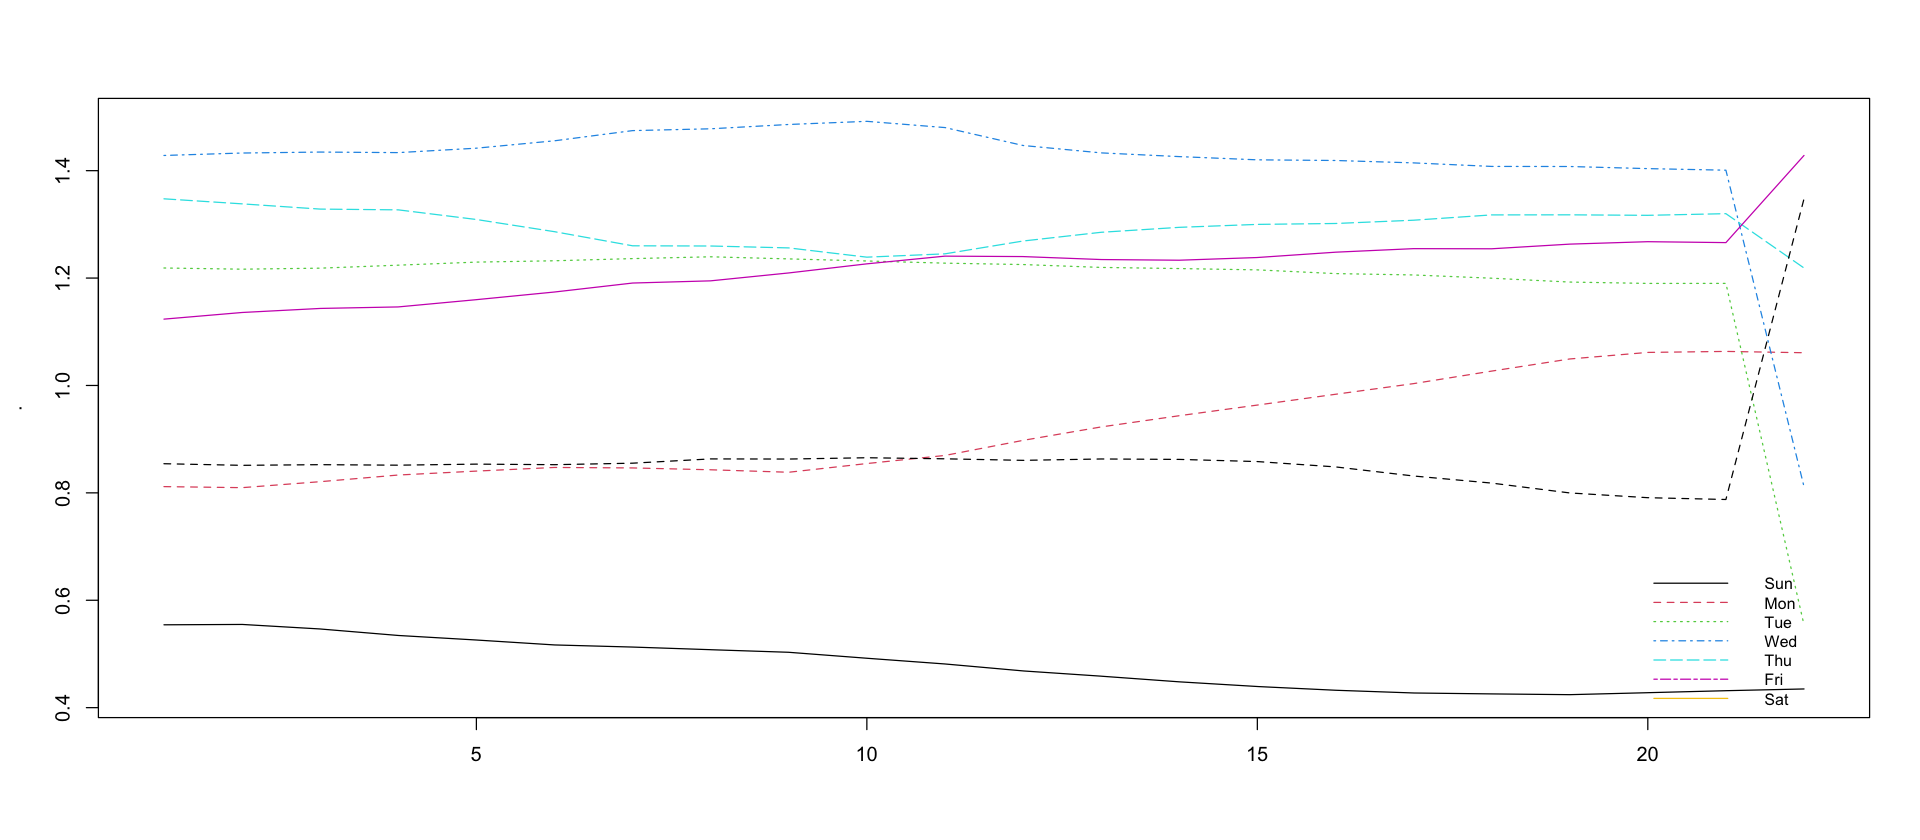

In [8]:
df_showcase %>%
    filter(variable == "W") %>%
    pull(mean) %>%
    head(-1) %>%
    matrix(nrow = 7) %>%
    t() %>%
    matplot(type = "l")
legend("bottomright", lty = 1:7, legend = c("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"), col = 1:7, cex = 0.8, bty = "n")


## Weekly average of weekday effects close to 1

In [9]:
df_showcase %>%
    filter(variable == "running_W") %>%
    select(mean, sd) %>%
    head(-3) %>%
    tail(-3) %>%
    summarize(mean(.$mean), mean(.$sd))


mean(.$mean),mean(.$sd)
<dbl>,<dbl>
1.057787,0.006446631


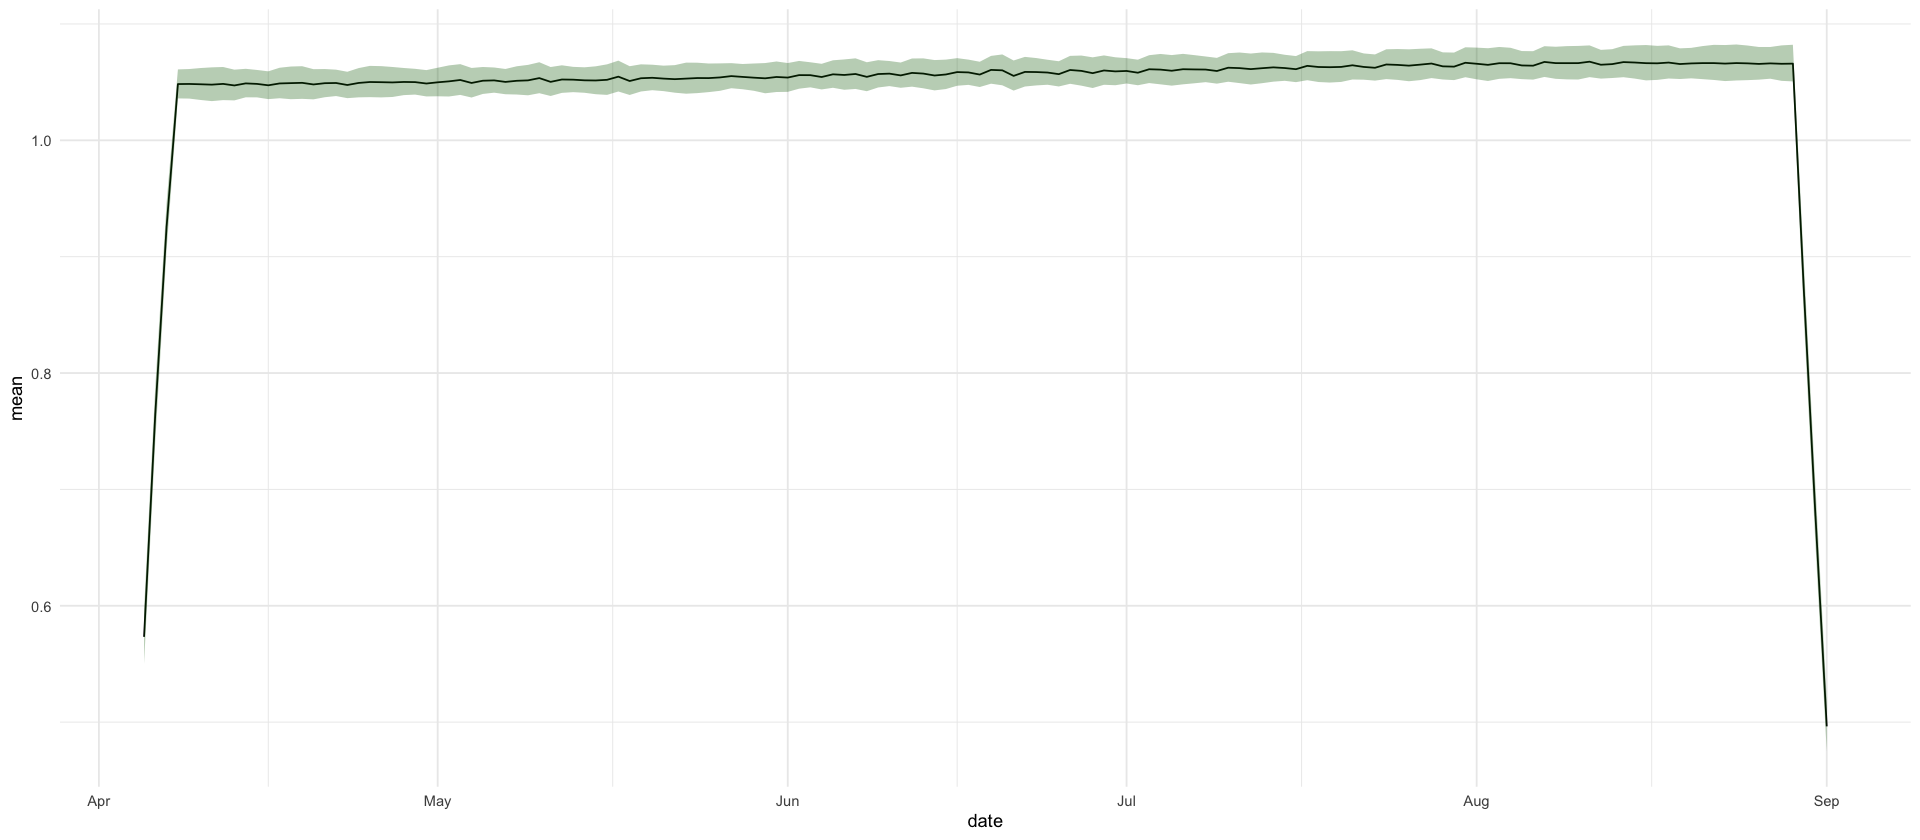

In [10]:
df_showcase %>%
    filter(variable == "running_W") %>%
    ggplot(aes(date, mean)) +
    geom_line() +
    geom_ribbon(aes(ymin = `0.025`, ymax = `0.975`), fill = "darkgreen", alpha = .3)


## Heavier tails than normal tails in mean M.

[1] 0.9997839

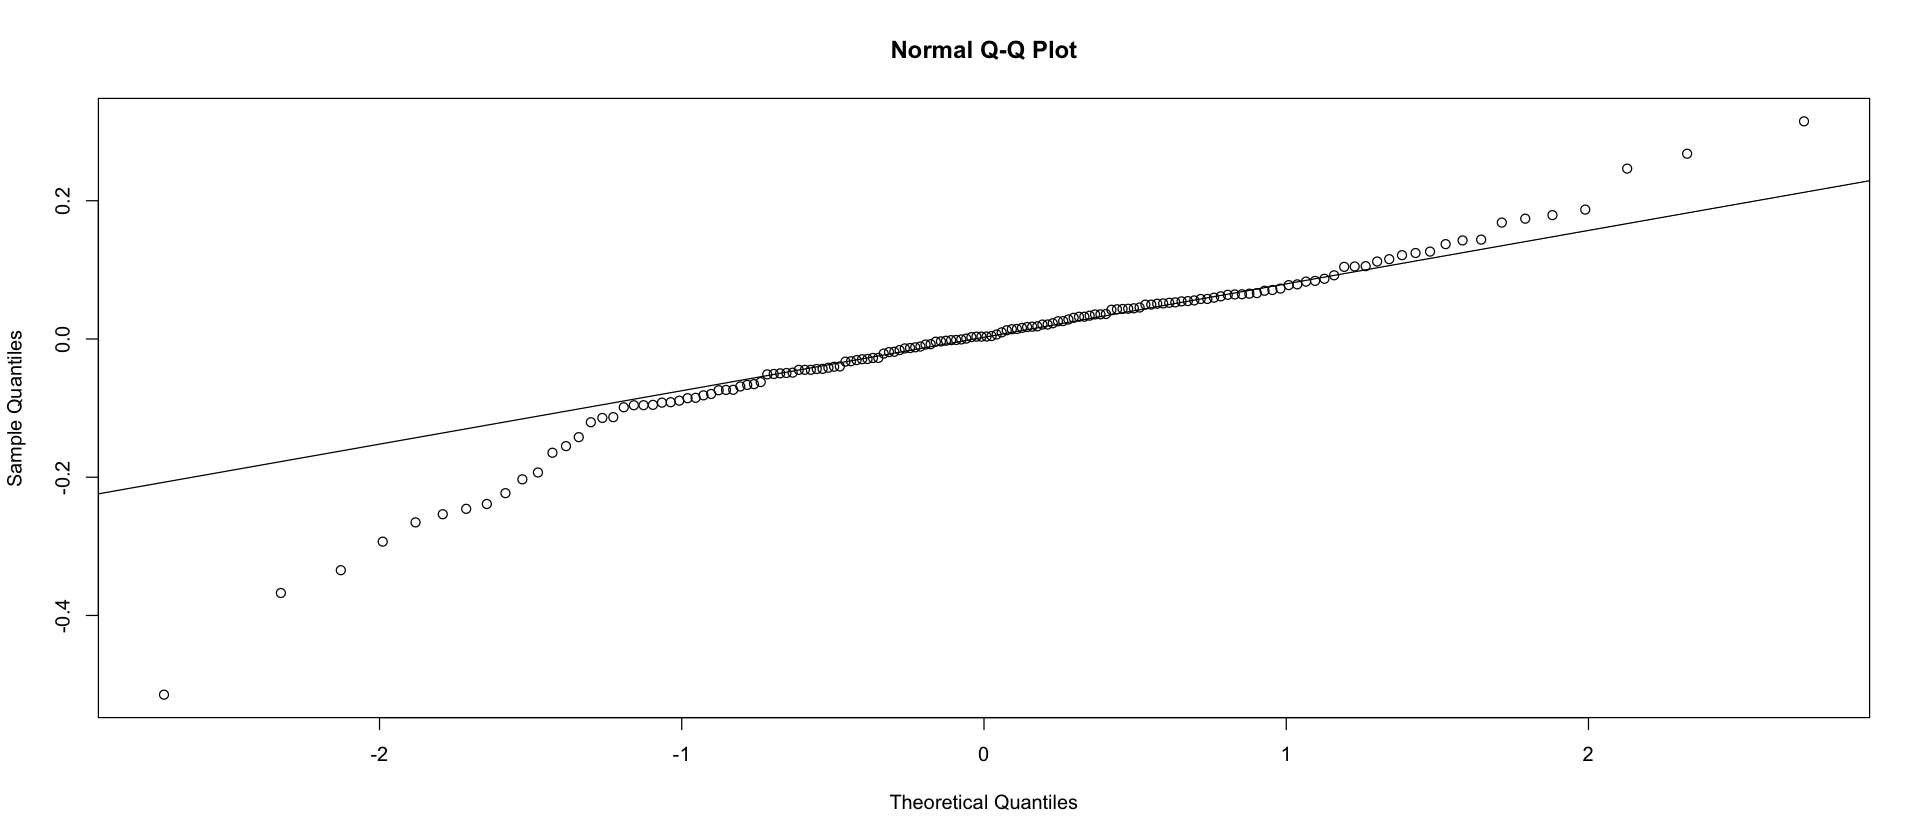

In [11]:
mean_Ms <- df_showcase %>%
    filter(variable == "M") %>%
    pull(mean)

mean(mean_Ms)

qqnorm(log(mean_Ms))
qqline(log(mean_Ms))


# Christmas model

## parameters

In [12]:
theta_christmas <- read_csv(here("data/results/4_christmas_model/thetas.csv")) %>%
    rename("\\rho" = 2)
theta_christmas_miss <- read_csv(here("data/results/4_christmas_model/thetas_miss.csv")) %>%
    rename("\\rho" = 2)

sds_christmas <- theta_christmas %>%
    mutate(across(where(is.numeric), ~ exp(.x / 2)))
sds_christmas_miss <- theta_christmas_miss %>%
    mutate(across(where(is.numeric), ~ exp(.x / 2)))


### `tables/christmas-parameters.tex`

In [19]:
# use scientific notation
sds_christmas %>%
    mutate(model = "full") %>%
    bind_rows(sds_christmas_miss %>% mutate(model = "missing")) %>%
    select(-model) %>%
    rename_with(function(col) str_glue("$\\hat\\sigma_{{ {col} }}$"), where(is.numeric)) %>%
    kable(format = "latex", format.args = list(scipen = 2, digits = 2), booktabs = T, escape = F) %>%
    pack_rows("all observations", 1, 3) %>%
    pack_rows("christmas removed", 4, 6) %>%
    cat(., file = here("tables/christmas-parameters.tex"))


## Predictions

In [14]:
df_christmas <- read_predictions(
    here("data/results/4_christmas_model/predictions.npy"),
    seq(ymd("2020-10-01"), ymd("2021-02-28"), by = "1 day"),
    c("I", "$\\rho$", "M", "W", "running_W", "$p^s_1$", "$p^s_2$", "$p^s_3$", "$p^s_4$", "$p_1$", "$p_2$", "$p_3$", "$p_4$", "$W_{q_1}", "W_{q_2}", "W_{q_3}")
)

df_christmas_missing <- read_predictions(
    here("data/results/4_christmas_model/predictions_miss.npy"),
    seq(ymd("2020-10-01"), ymd("2021-02-28"), by = "1 day"),
    c("I", "$\\rho$", "M", "W", "running_W", "$p^s_1$", "$p^s_2$", "$p^s_3$", "$p^s_4$", "$p_1$", "$p_2$", "$p_3$", "$p_4$", "$W_{q_1}", "W_{q_2}", "W_{q_3}")
)


In [15]:
missing_indices <- 80:109
dates_missing <- sort(unique(df_christmas$date))[missing_indices]
range(dates_missing)


[1] "2020-12-19" "2021-01-17"

pdf 
  2

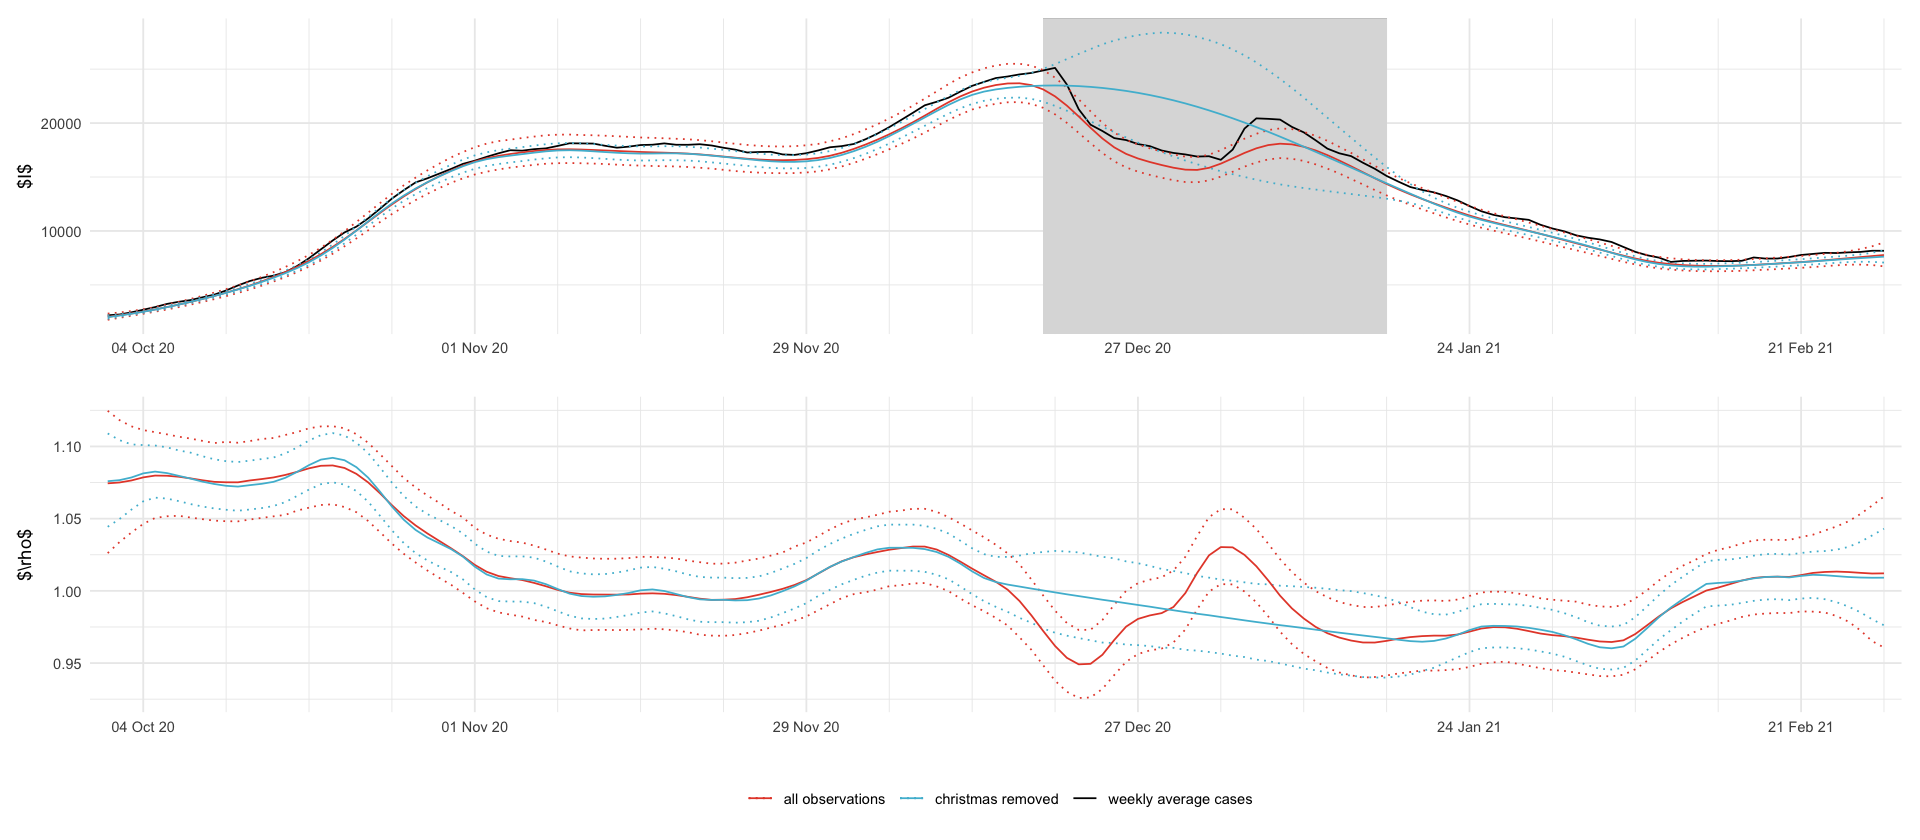

In [16]:
df_plot <- rbind(
    mutate(df_christmas, model = "all observations"),
    mutate(df_christmas_missing, model = "christmas removed")
) %>%
    select(model, date, variable, mean, `0.025`, `0.975`) %>%
    filter(variable %in% c("I", "$\\rho$"))

total_df_smoothed <- total_df %>%
    mutate(total = rollmean(total, 7, 0, True, align = "center")) %>%
    filter(date %in% unique(df_plot$date)) %>%
    mutate(model = "weekly average cases")

plt_I <- df_plot %>%
    filter(variable == "I") %>%
    ggplot(aes(date, mean, color = model)) +
    geom_rect(xmin = min(dates_missing), xmax = max(dates_missing), ymin = -Inf, ymax = Inf, fill = "gray", alpha = .01, inherit.aes = F) +
    geom_line(aes(date, total), data = total_df_smoothed) +
    # geom_ribbon(aes(ymin = `0.025`, ymax = `0.975`, fill = model), alpha = .3) +
    geom_line(aes(y = `0.025`, color = model), linetype = "dotted") +
    geom_line(aes(y = `0.975`, color = model), linetype = "dotted") +
    geom_line() +
    labs(x = "", y = "$I$", fill = "", color = "") +
    scale_color_manual(values = c("all observations" = pal_npg()(3)[1], "christmas removed" = pal_npg()(3)[2], "weekly average cases" = "black"))

plt_rho <- df_plot %>%
    filter(variable == "$\\rho$") %>%
    ggplot(aes(date, mean, color = model)) +
    # geom_rect(xmin = min(dates_missing), xmax = max(dates_missing), ymin = -Inf, ymax = Inf, fill = "gray80", alpha = .01, inherit.aes = F) +
    # geom_ribbon(aes(ymin = `0.025`, ymax = `0.975`, fill = model), alpha = .3) +
    geom_line(aes(y = `0.025`, color = model), linetype = "dotted", show.legend = F) +
    geom_line(aes(y = `0.975`, color = model), linetype = "dotted", show.legend = F) +
    geom_line(show.legend = F) +
    labs(x = "", y = "$\\rho$", fill = "", color = "")


plt_I / plt_rho + plot_layout(guides = "collect") & theme(legend.position = "bottom") & scale_x_four_weekly()

ggsave_tikz(here("tikz/christmas_prediction_intervals_I_rho.tex"))


### median in christmas period smaller than mean for missing model

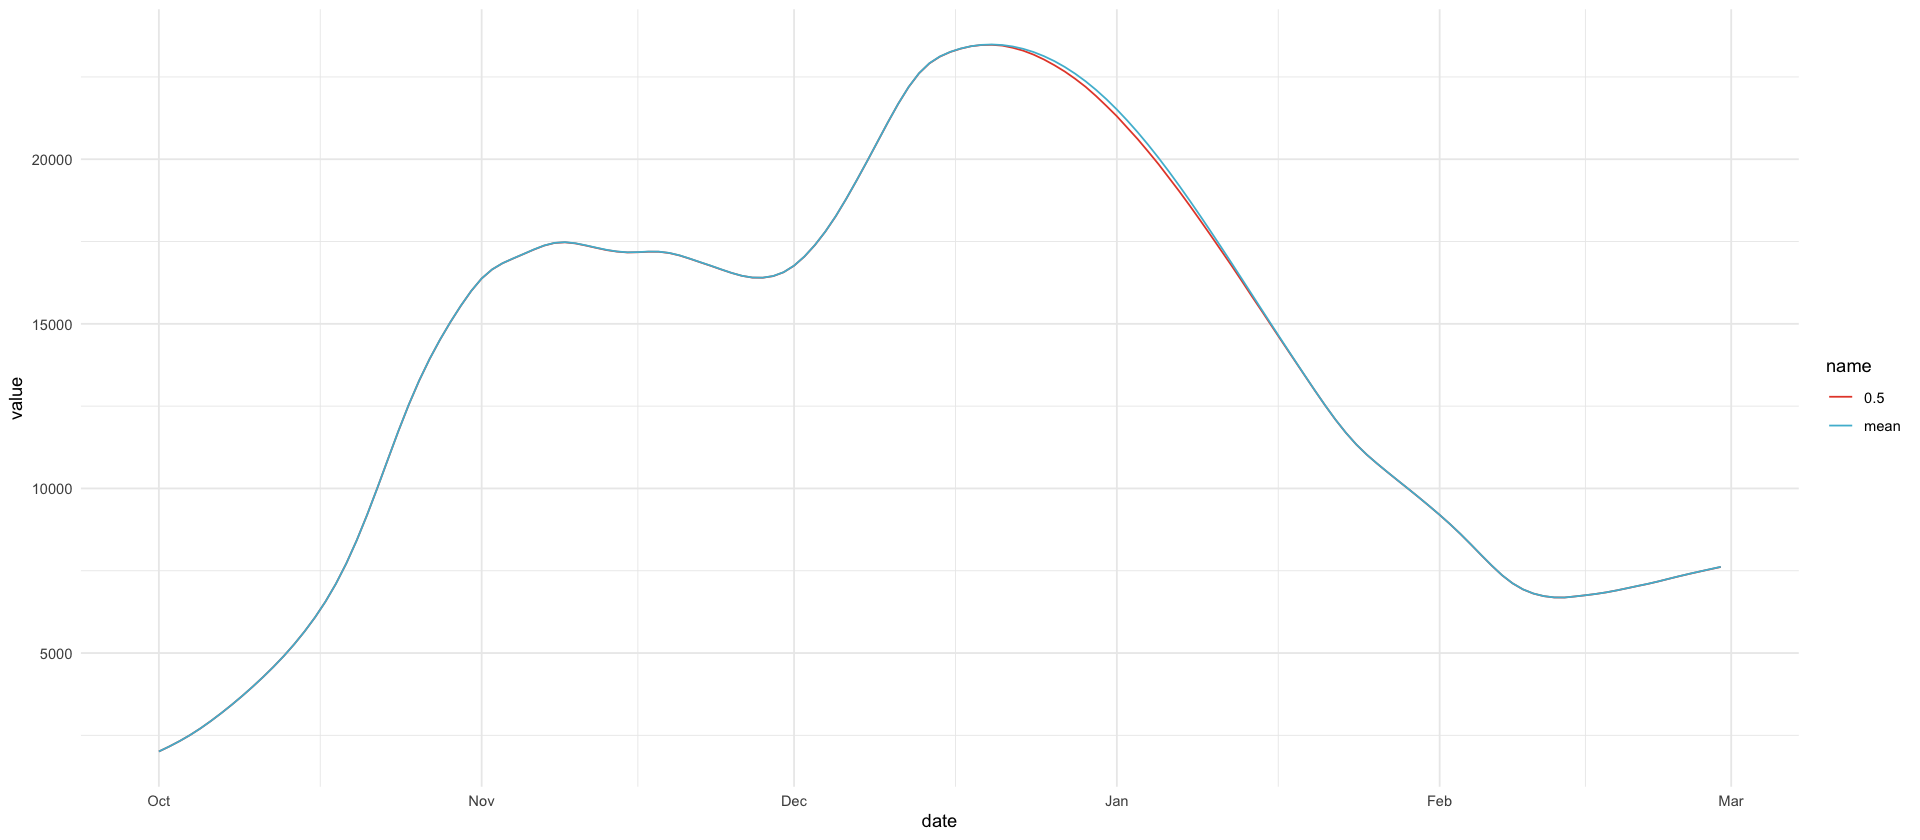

In [17]:
df_christmas_missing %>%
    filter(variable == "I") %>%
    select(date, mean, `0.5`) %>%
    pivot_longer(-date) %>%
    ggplot(aes(date, value, color = name)) +
    geom_line()


### `tikz/christmas_delay_probs.tex`

pdf 
  2

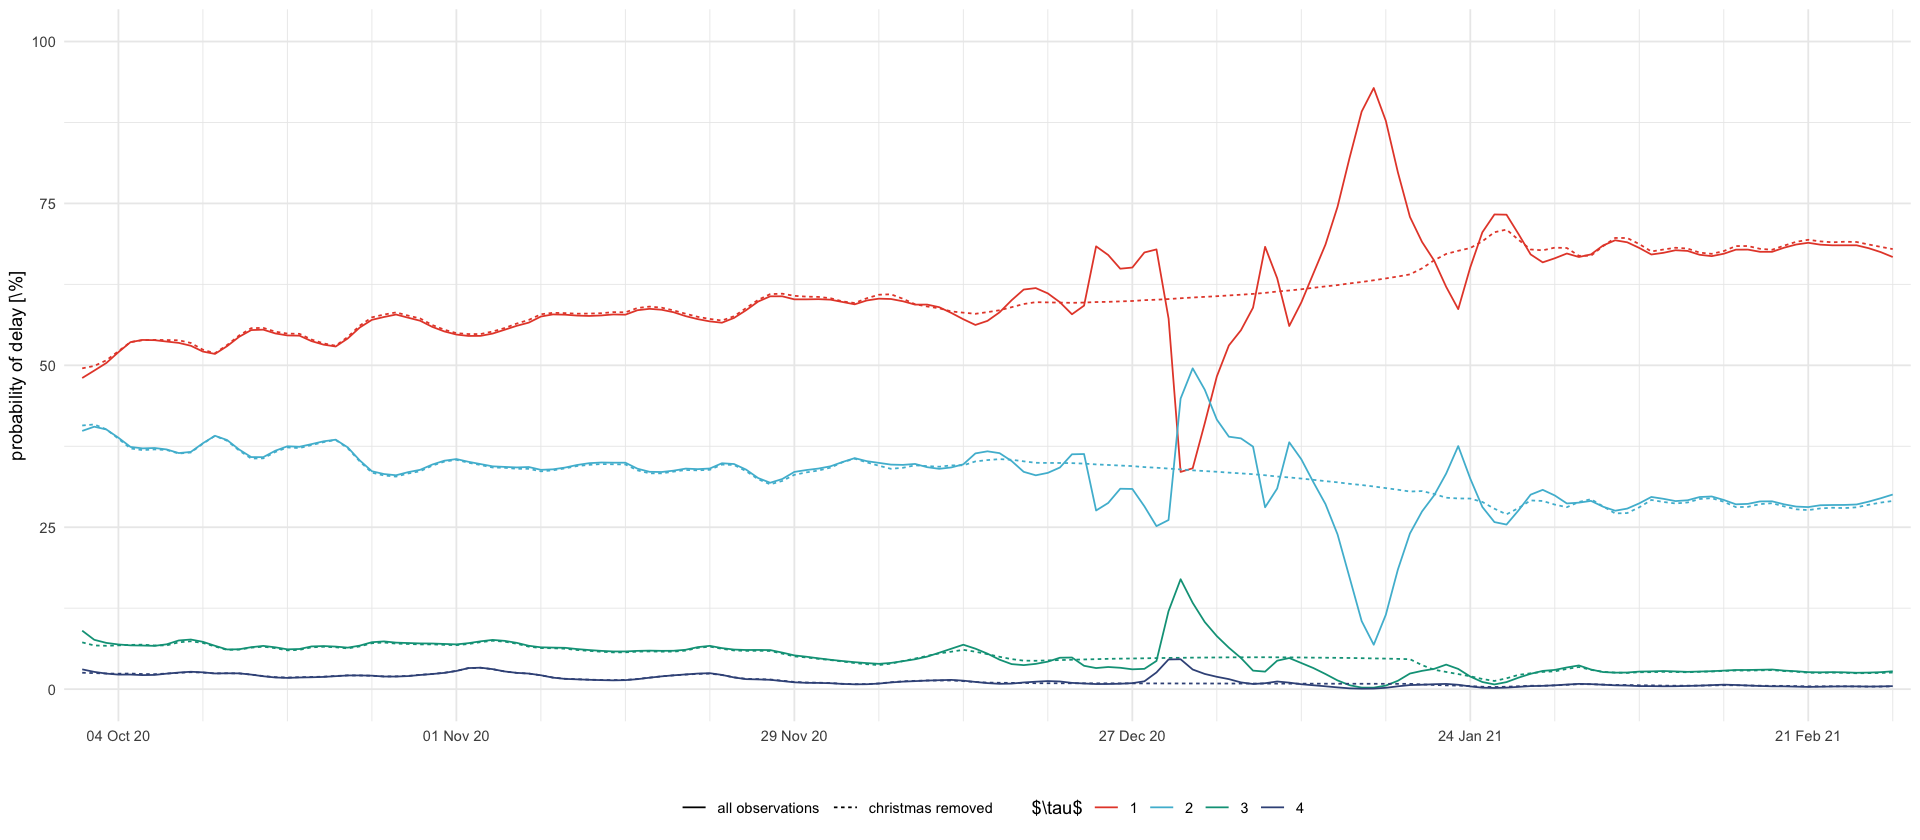

In [20]:
df_plot <- rbind(
    mutate(df_christmas, model = "all observations"),
    mutate(df_christmas_missing, model = "christmas removed")
) %>%
    select(model, date, variable, mean, `0.025`, `0.975`) %>%
    filter(str_starts(variable, "\\$p\\^s")) %>%
    mutate(delay = str_extract(variable, "\\d+")) %>%
    select(-variable)


df_plot %>%
    ggplot(aes(date, 100 * mean, color = delay, linetype = model)) +
    geom_line() +
    ylim(0, 100) +
    scale_x_four_weekly() +
    labs(x = "", y = "probability of delay [\\%]", color = "$\\tau$", linetype = "") +
    theme(legend.position = "bottom")

ggsave_tikz(here("tikz/christmas_delay_probs.tex"), height = 1 / 2 * default_height)
